In [1]:
!pip install datasets
!pip install faiss-cpu

In [2]:
import datasets
import faiss
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from typing import Callable, Iterable
from app.dataset.homer_dataset import HomerDataset, CEDataset, prepare_data
from app.biencoder.sentence_bert import SentenceBert, encode, mini_batch, get_train_step_fn, get_val_step_fn
from app.faiss.get_vocab import get_vocab
from app.reranker.reranker import (CrossEncoderBert,
                                   test_cross_encoder_bert,
                                   train_step_fn as train_step_fn_ce,
                                   val_step_fn as val_step_fn_ce,
                                   mini_batch as mini_batch_ce,
                                   get_ranked_docs, get_1st_rank
)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

Device: cuda


In [5]:
seed = 10

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Crate dataset

In [6]:
# Загрузим данные из источника и поготовим токенизатор
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
raw_df = pd.read_csv('data/simpsons_dataset.csv')
raw_df.head(10)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...
5,Martin Prince,I don't think there's anything left to say.
6,Edna Krabappel-Flanders,Bart?
7,Bart Simpson,Victory party under the slide!
8,NaN,NaN
9,Lisa Simpson,Mr. Bergstrom! Mr. Bergstrom!


In [7]:
%%time
# Инициализируем датасет
pre_dataset = prepare_data(raw_df)
homer_dataset = HomerDataset(pre_dataset, tokenizer)

CPU times: user 46 s, sys: 6.44 s, total: 52.4 s
Wall time: 41 s


In [8]:
len(homer_dataset)

124701

In [9]:
# Разобьём датасет на трейн и тест
train_ratio = 0.8
n_total = len(homer_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(homer_dataset, [n_train, n_val])

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# BI-Encoder

In [10]:
model = SentenceBert(device=device)
model_location = "/content/drive/MyDrive/weights/sentence_bert_biencoder"

In [16]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-6)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.CrossEntropyLoss()
model.to(device)

SentenceBert(
  (bert_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Line

In [18]:
%%time

n_epochs = 1

train_step_fn = get_train_step_fn(model, optimizer, scheduler, loss_fn)
val_step_fn = get_val_step_fn(model, loss_fn)

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn, device=device)
    train_mini_batch_losses += _train_mini_batch_losses
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False, device=device)
        val_mini_batch_losses += _val_mini_batch_losses
        val_losses.append(val_loss)


Training ...
step     0/6235, loss =  1.067
step  1600/6235, loss =  0.365
step  3200/6235, loss =  0.520
step  4800/6235, loss =  0.592

Validating ...
step     0/1559, loss =  0.546
CPU times: user 34min 59s, sys: 36.9 s, total: 35min 36s
Wall time: 35min 53s


In [19]:
model.bert_model.save_pretrained(model_location)

In [20]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

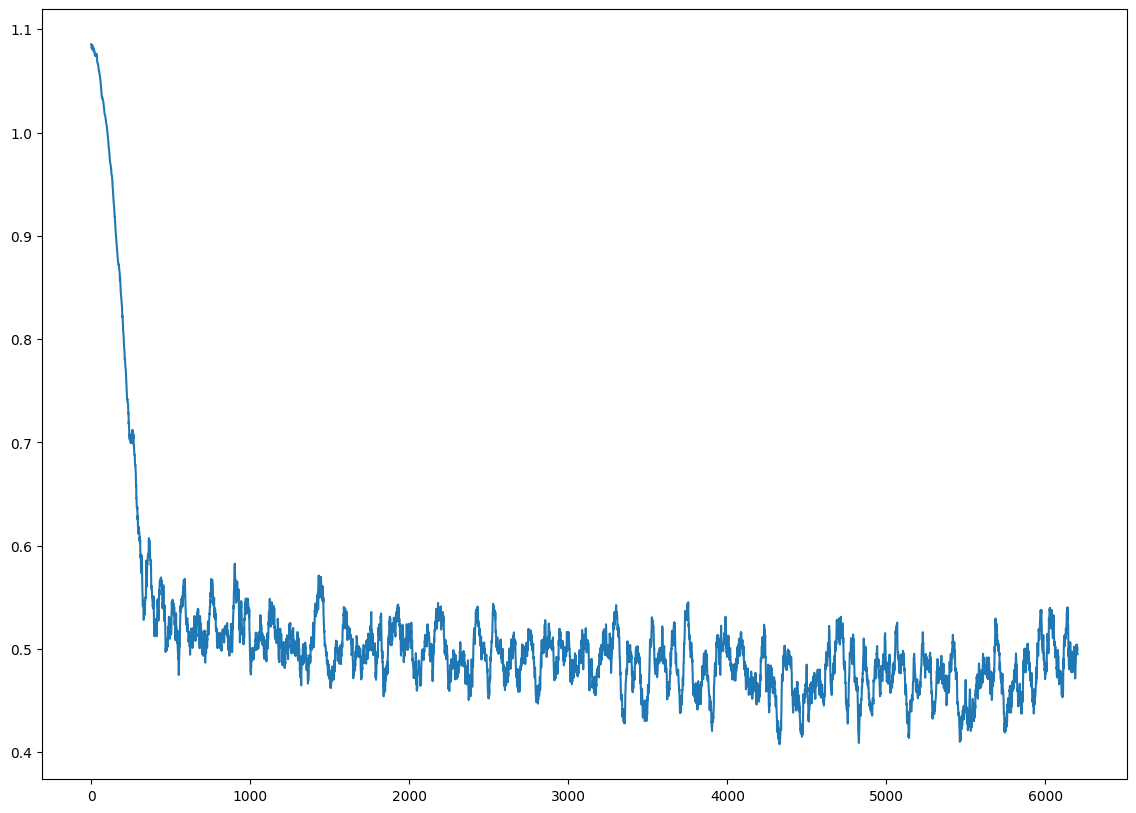

In [21]:
fix, ax = plt.subplots(figsize=(14, 10))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

In [11]:
model.bert_model = model.bert_model.from_pretrained(model_location)

In [17]:
sentences = [
    'Hello, Homer',
    "Hi!",
    "Were is Lisa?",
    "She should be at school",
    "Your house is on fire",
    "Woo hoo",
    "What is your name?",
    "I am Homer"
]

In [18]:
model.to(device)
pooled_embeds = encode(sentences, model.bert_tokenizer, model.bert_model, device)
pooled_embeds = pooled_embeds.cpu().detach().numpy()

In [27]:
def plot_heatmap(similarity_matrix: np.array, sentences: list[str]) -> None:
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(similarity_matrix, cmap='YlGn', interpolation='nearest')

    ax.set_yticks(np.arange(len(sentences)), labels=[txt[:50] + "..." for txt in sentences])
    ax.set_xticks(np.arange(len(sentences)), labels=[txt[:50] + "..." for txt in sentences])

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(sentences)):
        for j in range(len(sentences)):
            text = ax.text(j, i, round(similarity_matrix[i, j], 2),
                           ha="center", va="center", color="w")

    fig.tight_layout()
    plt.show()

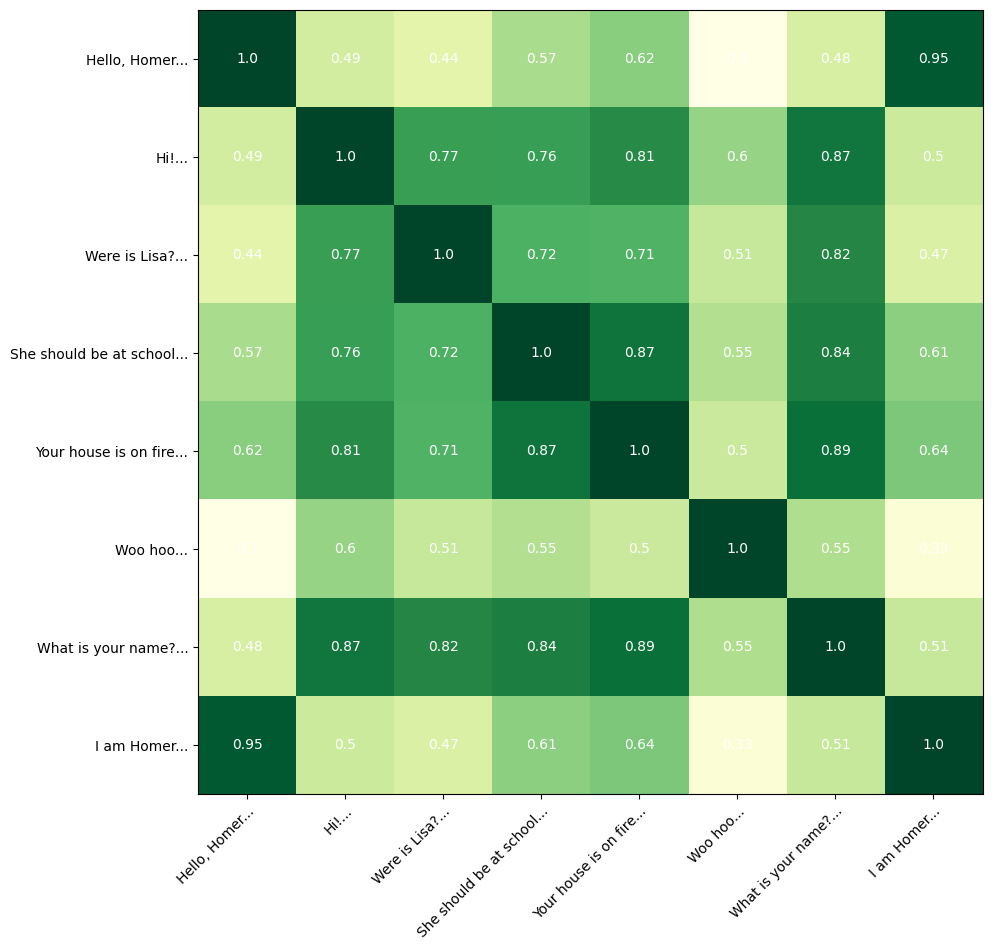

In [28]:
similarity_matrix = cosine_similarity(pooled_embeds)
plot_heatmap(similarity_matrix, sentences)

# Faiss to find response-candidates

In [12]:
def embed_bert_cls(text: str, model, tokenizer) -> np.array:
    t = tokenizer(text, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**{k: v.to(model.device) for k, v in t.items()})
    embeddings = model_output.last_hidden_state[:, 0, :]
    embeddings = torch.nn.functional.normalize(embeddings)
    return embeddings[0].cpu().numpy()

print(embed_bert_cls('Hello, Homer', model.bert_model, model.bert_tokenizer).shape)

(768,)


In [30]:
homer_vocab = get_vocab(raw_df, 'Homer Simpson')
homer_vocab.append('UNK')

In [14]:
#base = np.array([embed_bert_cls(phrase, model.bert_model, model.bert_tokenizer) for phrase in tqdm(homer_vocab)])
#np.save( "/content/drive/MyDrive/weights/faiss_base_tokens.npy", base) #"app/static/weights
#np.save( "/content/drive/MyDrive/weights/faiss_base_originals.npy",  np.array(homer_vocab))
base = np.load("/content/drive/MyDrive/weights/faiss_base_tokens.npy")
homer_vocab = np.load("/content/drive/MyDrive/weights/faiss_base_originals.npy")
index = faiss.IndexFlatL2(base.shape[1])
index.add(base)

In [19]:
k = 4
query = "Hello, what's your name?"
pooled_embeds = encode(query, model.bert_tokenizer, model.bert_model, device)
pooled_embeds = pooled_embeds.cpu().detach().numpy()
D, I = index.search(pooled_embeds, 10)
candidates = [homer_vocab[i] for i in I[0]]
for candidate in candidates:
  print(candidate)

Hello, what's this?
Hello? Can anybody hear me?
Hello, little girl, who do you belong to?
Hello, son. Where have you been?
Hey, what's that sound?
Hey, how much is it?
Hello? Hello? Hello taste... where are you?
Hey, what's up?
Hey, open up! I've been standing here all morning.
Wakeup call? It's two AM!


# Cross-Encoder to rerank candidates

In [20]:
%%time
ce_dataset = CEDataset(pre_dataset, tokenizer)
ce_model = CrossEncoderBert().to(device)

CPU times: user 22.9 s, sys: 2.77 s, total: 25.7 s
Wall time: 17.3 s


In [21]:
train_ratio = 0.8
n_total = len(ce_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(ce_dataset, [n_train, n_val])

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [22]:
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.MSELoss()

In [24]:
%%time

n_epochs = 2 # Модель быстро начинает переобучаться

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    print(f"\nEpoch {epoch}")
    train_loss, _train_mini_batch_losses = mini_batch_ce(ce_model, train_dataloader, optimizer=optimizer, scheduler=scheduler,
                                                         loss_fn=loss_fn, step_fn=train_step_fn_ce, is_training=True,  batch_size=batch_size, device=device)
    train_mini_batch_losses.extend(_train_mini_batch_losses)
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch_ce(ce_model, val_dataloader, optimizer=optimizer, scheduler=scheduler,
                                                         loss_fn=loss_fn, step_fn=val_step_fn_ce, is_training=False, batch_size=batch_size, device=device)
        val_mini_batch_losses.extend(_val_mini_batch_losses)
        val_losses.append(val_loss)


Epoch 1
Step     0/6235, Loss = 0.560
Step    64/6235, Loss = 0.230
Step   128/6235, Loss = 0.559
Step   192/6235, Loss = 0.256
Step   256/6235, Loss = 0.234
Step   320/6235, Loss = 0.292
Step   384/6235, Loss = 0.422
Step   448/6235, Loss = 0.531
Step   512/6235, Loss = 0.185
Step   576/6235, Loss = 0.490
Step   640/6235, Loss = 0.489
Step   704/6235, Loss = 0.339
Step   768/6235, Loss = 0.254
Step   832/6235, Loss = 0.325
Step   896/6235, Loss = 0.601
Step   960/6235, Loss = 0.413
Step  1024/6235, Loss = 0.044
Step  1088/6235, Loss = 0.201
Step  1152/6235, Loss = 0.455
Step  1216/6235, Loss = 0.371
Step  1280/6235, Loss = 0.427
Step  1344/6235, Loss = 0.724
Step  1408/6235, Loss = 0.199
Step  1472/6235, Loss = 0.443
Step  1536/6235, Loss = 0.333
Step  1600/6235, Loss = 0.548
Step  1664/6235, Loss = 0.381
Step  1728/6235, Loss = 0.117
Step  1792/6235, Loss = 0.398
Step  1856/6235, Loss = 0.216
Step  1920/6235, Loss = 0.443
Step  1984/6235, Loss = 0.278
Step  2048/6235, Loss = 0.295
S

In [25]:
window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

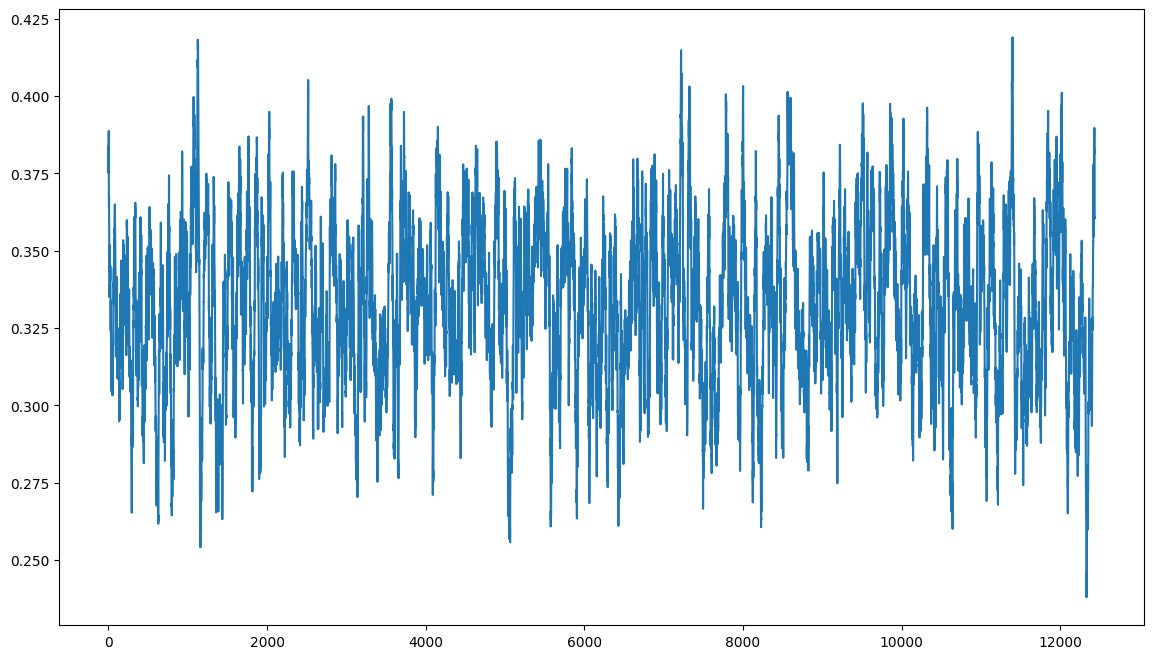

In [26]:
fix, ax = plt.subplots(figsize=(14, 8))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

In [35]:
get_ranked_docs(tokenizer=tokenizer, finetuned_ce=ce_model, query=query, corpus=candidates, device=device)

Query - Hello, what's your name? [Finetuned Cross-Encoder]
---
0.45	Hey, what's that sound?
0.44	Hello? Can anybody hear me?
0.44	Hey, how much is it?
0.44	Wakeup call? It's two AM!
0.44	Hey, open up! I've been standing here all morning.
0.44	Hello, little girl, who do you belong to?
0.43	Hello, what's this?
0.43	Hey, what's up?
0.43	Hello, son. Where have you been?
0.43	Hello? Hello? Hello taste... where are you?


In [36]:
ce_model.bert_model.save_pretrained("/content/drive/MyDrive/weights/ce_bert")

In [38]:
get_1st_rank(tokenizer, ce_model, query, candidates, device=device)

"Hey, what's that sound?"